In [1]:
import os
import sys
import pandas as pd
sys.path.append("../models")
from cnn_model import CNNModel

2025-03-26 15:19:37.645303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-X.Y/lib64
2025-03-26 15:19:37.645322: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
partition = input("Inserisci la partizione che vuoi utilizzare")
domain = "frequency" if partition[:2].lower() == "pf" else "time"
print("Hai inserito la partizione: ", partition)
partition = os.path.join("../partitioning/npy", partition)

foldername = input("Inserisci il nome della cartella dove salvare i risultati")
print("Hai inserito la cartella: ", foldername)
foldername = os.path.join(domain, "training_cnn", foldername)
print(foldername)

Hai inserito la partizione:  pt_sq200_over0
Hai inserito la cartella:  test_52
time/training_cnn/test_52


In [3]:
import re

def estrai_parametri(stringa):
    # Trova i singoli parametri se presenti
    sq_match = re.search(r"sq(\d+)", stringa)
    ws_match = re.search(r"ws(\d+)", stringa)
    st_match = re.search(r"st(\d+)", stringa)

    # Usa .group(1) se esiste, altrimenti None
    seq_len = int(sq_match.group(1)) if sq_match else None
    window_size = int(ws_match.group(1)) if ws_match else None
    stride = int(st_match.group(1)) if st_match else None

    return {
        "sequence_length": seq_len,
        "window_size": window_size,
        "stride": stride
    }

result = estrai_parametri(partition)

seq_len = result['sequence_length']
win_size = result['window_size']
stride = result['stride']


In [4]:
def load_partitions(root_path):
    file_names = ["X_train.csv", "X_test.csv", "X_val.csv", "y_train.csv", "y_test.csv", "y_val.csv"]
    datasets = [pd.read_csv(os.path.join(root_path, file)).values for file in file_names]
    return tuple(datasets)

# load data
X_train, X_test, X_val, y_train, y_test, y_val = load_partitions(partition)

# show partitions dimention
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (895, 200), y_train shape: (895, 1)
X_test shape: (192, 200), y_test shape: (192, 1)
X_val shape: (191, 200), y_val shape: (191, 1)


In [5]:
if domain == "frequency":
    X_train = X_train.reshape(-1, seq_len, win_size*2)
    X_val = X_val.reshape(-1, seq_len, win_size*2)
    X_test = X_test.reshape(-1, seq_len, win_size*2)
    print(X_train.shape)
    print(X_val.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_val.shape)
    print(y_test.shape)

In [6]:
input_shape = (
    (X_train.shape[1], X_train.shape[2])
    if domain == "frequency"
    else (X_train.shape[1], 1)
)

print(f"Input shape: {input_shape}")

Input shape: (200, 1)


In [7]:
# initialize model
cnn_model = CNNModel(input_shape, foldername, output_units=y_train.shape[1])

# show model structure
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 198, 64)           256       
                                                                 
 dropout (Dropout)           (None, 198, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 196, 64)           12352     
                                                                 
 dropout_1 (Dropout)         (None, 196, 64)           0         
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 128)               1605760   
                                                                 
 dense_1 (Dense)             (None, 1)                 1

2025-03-26 15:19:46.273584: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-03-26 15:19:46.273628: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (paolo-Katana-15-B13VFK): /proc/driver/nvidia/version does not exist
2025-03-26 15:19:46.274343: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
#cnn_model.train(X_train, y_train, validation_data=(X_val, y_val))
cnn_model.train(X_train, y_train, validation_data=(X_val, y_val))

Epoch 1/100
24/28 [========================>.....] - ETA: 0s - loss: 0.0204 - mae: 0.1107 - root_mean_squared_error: 0.1399
Epoch 1: val_loss improved from inf to 0.01713, saving model to time/training_cnn/test_52/best_model.keras
28/28 [==============================] - 1s 16ms/step - loss: 0.0196 - mae: 0.1089 - root_mean_squared_error: 0.1370 - val_loss: 0.0171 - val_mae: 0.1013 - val_root_mean_squared_error: 0.1300
Epoch 2/100
27/28 [===========================>..] - ETA: 0s - loss: 0.0175 - mae: 0.1018 - root_mean_squared_error: 0.1304
Epoch 2: val_loss improved from 0.01713 to 0.01711, saving model to time/training_cnn/test_52/best_model.keras
28/28 [==============================] - 0s 10ms/step - loss: 0.0175 - mae: 0.1020 - root_mean_squared_error: 0.1305 - val_loss: 0.0171 - val_mae: 0.1013 - val_root_mean_squared_error: 0.1299
Epoch 3/100
24/28 [========================>.....] - ETA: 0s - loss: 0.0164 - mae: 0.0996 - root_mean_squared_error: 0.1268
Epoch 3: val_loss improved

In [9]:
#cnn_model.evaluate(X_test, y_test)
cnn_model.evaluate(X_test, y_test)


Valutazione completata.


{'detailed': {'Output': ['Unico'],
  'MSE': [0.010800776522046548],
  'RMSE': [0.10392678443041788],
  'MAE': [0.08052592660957832],
  'R2': [0.2804136268154225]},
 'mean': {'Output': ['Unico'],
  'MSE': [0.010800776522046548],
  'RMSE': [0.10392678443041788],
  'MAE': [0.08052592660957832],
  'R2': [0.2804136268154225]}}

In [10]:
cnn_model.save_model()

Modello salvato in time/training_cnn/test_52/cnn_model.keras


In [11]:
cnn_model.save_summary()

Sommario del modello salvato in time/training_cnn/test_52/model_summary.txt


In [12]:
y_pred = cnn_model.predict(X_test)  
comparison_df = cnn_model.compare_predictions(y_test, y_pred)  

Confronto predizioni salvato in time/training_cnn/test_52/predictions_comparison.csv


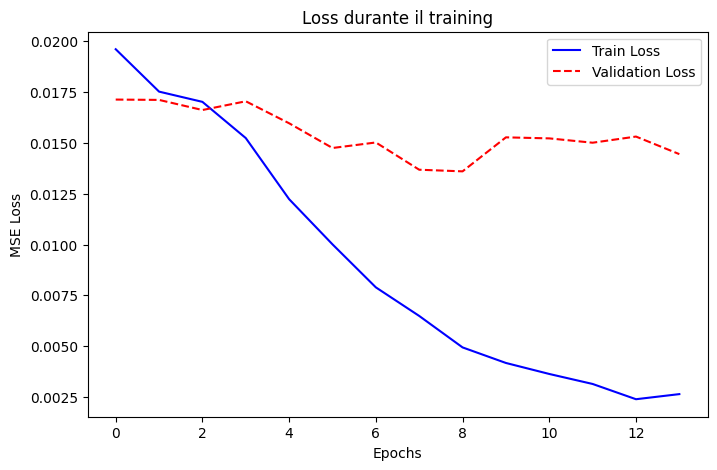

Grafico Loss salvato in time/training_cnn/test_52/loss_plot.png


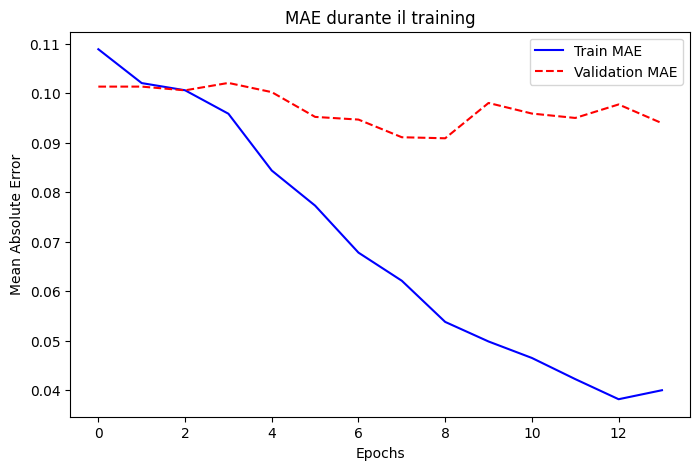

Grafico MAE salvato in time/training_cnn/test_52/mae_plot.png


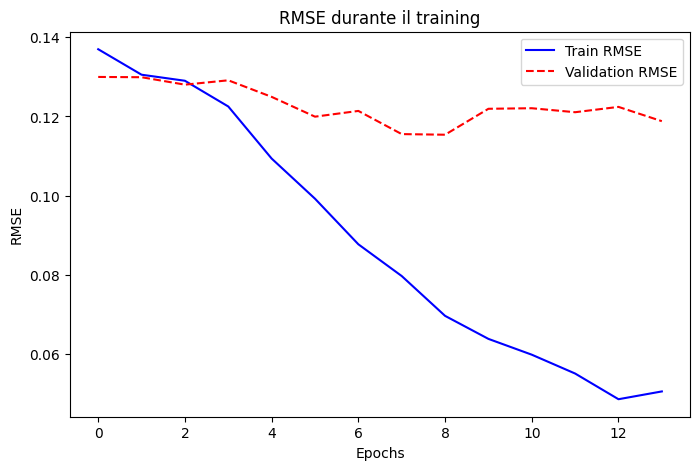

Grafico RMSE salvato in time/training_cnn/test_52/rmse_plot.png


In [13]:
cnn_model.plot_training_history()

In [14]:
cnn_model.save_training_info_json()

Informazioni di addestramento salvate in time/training_cnn/test_52/training_info.json
